## What is Product Recommendation?

<hr>

A product recommendation is basically a filtering system that seeks to predict and show the items that a user would like to purchase.

And if set up and configured properly, <b>it can significantly boost revenues, CTRs, conversions, and other important metrics.</b>

Moreover, they can have positive effects on <b>the user experience</b> as well, which translates into metrics that are harder to measure but are nonetheless of much importance to online businesses, such as customer satisfaction and retention.

<div class="alert alert-success"> <b>Recommendation is one of the best field where Data Science teams do have a chance to increase their visibility in a business by making a profound impact on the product.</b> </div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2

from recsys_helper import prod2vec, prod2vec_you_may_also_like, aggregate_vectors, prod2vec_base_on_last_4_purchased
from tqdm import tqdm

In [2]:
%%time

transactions_df = pd.read_parquet('./transactions.parquet')
customers_df = pd.read_csv('customers.csv', usecols=['customer_id'])
article_df = pd.read_csv('articles.csv', dtype = {'article_id': str})

CPU times: total: 13.1 s
Wall time: 11.1 s


In [3]:
# Assigning incremental ids to customers and articles
all_customers = customers_df['customer_id'].unique().tolist()
all_articles = article_df['article_id'].unique().tolist()

customer_ids = dict(list(enumerate(all_customers)))
article_ids = dict(list(enumerate(all_articles)))

transactions_df['customer_id'] = transactions_df['customer_id'].map({u: uidx for uidx, u in customer_ids.items()})
transactions_df['article_id'] = transactions_df['article_id'].map({i: iidx for iidx, i in article_ids.items()})

# del customers, articles
# gc.collect()

In [4]:
transactions_df.head(3)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,2,40179,0.050831,2
1,2018-09-20,2,10520,0.030492,2
2,2018-09-20,7,6387,0.015237,2


In [5]:
# filtered out repetitive transactions for 1 item in one day
transactions_df = transactions_df.groupby(['t_dat', 'customer_id', 'article_id']).size().reset_index()
transactions_df = transactions_df[['t_dat', 'customer_id', 'article_id']]

In [6]:
transactions_df = transactions_df[transactions_df['t_dat'] >= '2020-06-01']

print('start:', transactions_df['t_dat'].min())
print('end:', transactions_df['t_dat'].max())

start: 2020-06-01 00:00:00
end: 2020-09-22 00:00:00


In [7]:
# too many customer
print('total customer')

cust_total_trans = transactions_df.groupby('customer_id')['article_id'].size().to_frame('total_transactions').reset_index()
print('\nbefore filter:', cust_total_trans['customer_id'].nunique())

cust_total_trans = cust_total_trans[(cust_total_trans['total_transactions'] > 8) & (cust_total_trans['total_transactions'] <= 18)]
print('\nafter filter:', cust_total_trans['customer_id'].nunique())

total customer

before filter: 599002

after filter: 124802


In [8]:
customers = cust_total_trans['customer_id'].unique().tolist()

# shuffle customer ID's
random.shuffle(customers)

purchases_history = []

for cust_id in tqdm(customers):
    temp = transactions_df[transactions_df['customer_id'] == cust_id]['article_id'].tolist()
    purchases_history.append(temp)

100%|█████████████████████████████████████████████████████████████████████████| 124802/124802 [10:29<00:00, 198.37it/s]


## Skip Gram 

<hr>

We’re going to train a simple neural network with a single hidden layer to perform a certain task, but then we’re not actually going to use that neural network for the task we trained it on!

Instead, the goal is actually just to learn the weights of the hidden layer – we’ll see that these weights are actually the “word vectors” that we’re trying to learn.

We’re going to train the neural network to do the following. Given a specific word in the middle of a sentence (the input word), look at the words nearby (window size) and pick one at random. The network is going to tell us the probability for every word in our vocabulary of being the “nearby word” that we chose.

<div class="alert alert-success"> <b>the goal is actually just to learn the weights of the hidden layer</b> </div>

## The Hidden Layer

<img src="http://mccormickml.com/assets/word2vec/skip_gram_net_arch.png" alt="word2vec" width="600" align="left">

For our example, we’re going to say that we’re learning word vectors with 300 features.

So the hidden layer is going to be represented by a weight matrix with 10,000 rows (one for every word in our vocabulary) and 300 columns (one for every hidden neuron).

## Negative Sampling

<hr>

Training a neural network means taking a training example and adjusting all of the neuron weights slightly so that it predicts that training sample more accurately.

The size of our word vocabulary means that our skip-gram neural network has a tremendous number of weights,

all of which would be updated slightly by every one of our billions of training samples!

<div class="alert alert-success"> <b>Negative sampling addresses this by having each training sample only modify a small percentage of the weights, rather than all of them.<br><br>Here’s how it works:</b> </div>

With negative sampling, we are instead going to randomly select just a small number of “negative” words (let’s say 5) to update the weights for. (In this context, a “negative” word is one for which we want the network to output a 0 for). We will also still update the weights for our “positive” word (which is the word “quick” in our current example).

Recall that the output layer of our model has a weight matrix that’s 300 x 10,000. So we will just be updating the weights for our positive word (“quick”), plus the weights for 5 other words that we want to output 0.

That’s a total of 6 output neurons, and 1,800 weight values total.

<div class="alert alert-success"> <b>That’s only 0.06% of the 3M weights in the output layer!</b> </div>

In [9]:
%%time

model = prod2vec(purchases_history,
                 vector_size=64, 
                 window = 8, 
                 sg = 1, 
                 negative = 12, # The paper says that selecting 5-20 words works well for smaller datasets
                 alpha=0.03, 
                 min_alpha=0.0007, 
                 seed = 2022, 
                 epochs=10)

# other parameters
# min_count (int, default = 5) – Ignores all words with total frequency lower than this

CPU times: total: 4min 20s
Wall time: 1min 28s


In [10]:
available_products = pd.Series(model.wv.index_to_key)

len(available_products)

22992

In [ ]:
## --------------------------------------------------------------------------------------------------------------------- ##

## You may also like - Prod2Vec

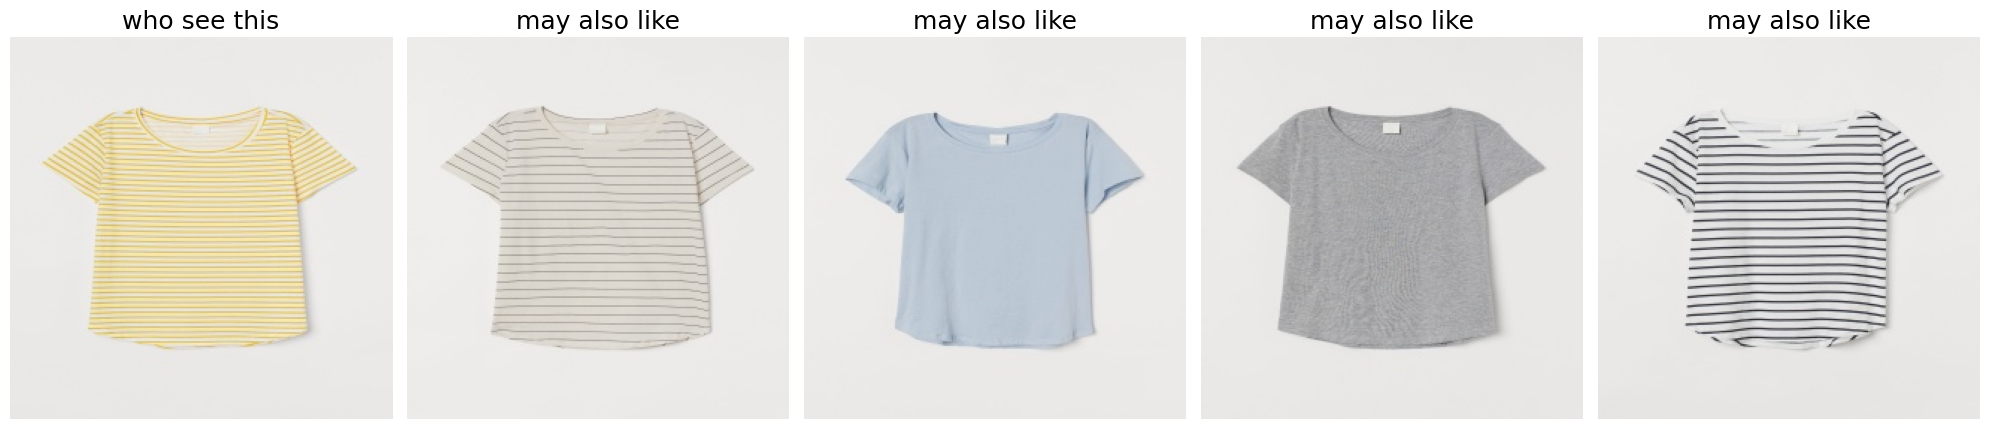

In [11]:
prod2vec_you_may_also_like(24869, model, article_ids)

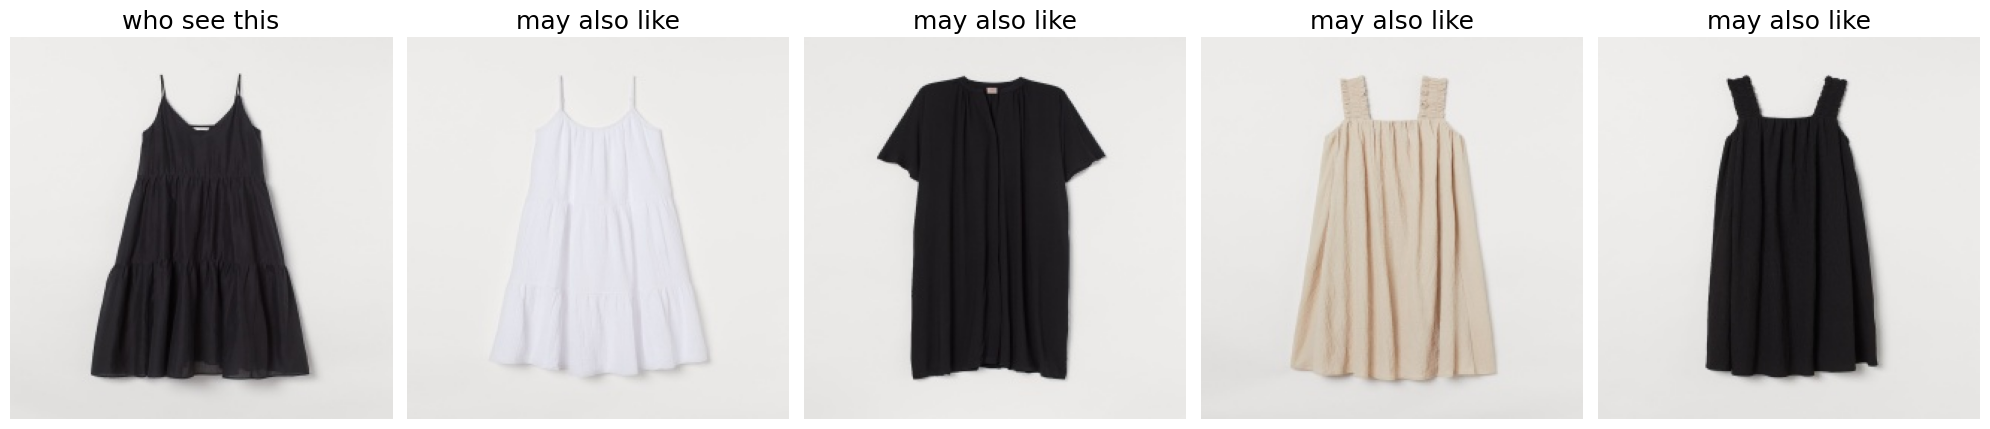

In [12]:
prod2vec_you_may_also_like(98366, model, article_ids)

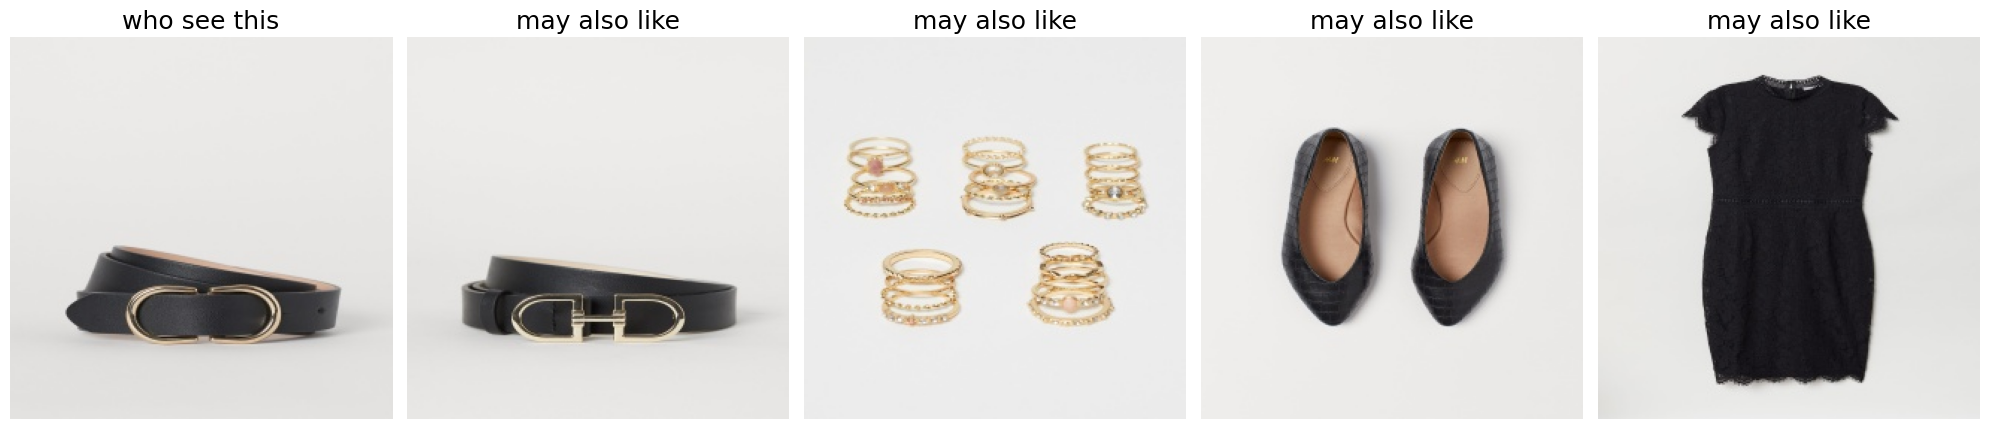

In [13]:
prod2vec_you_may_also_like(74152, model, article_ids)

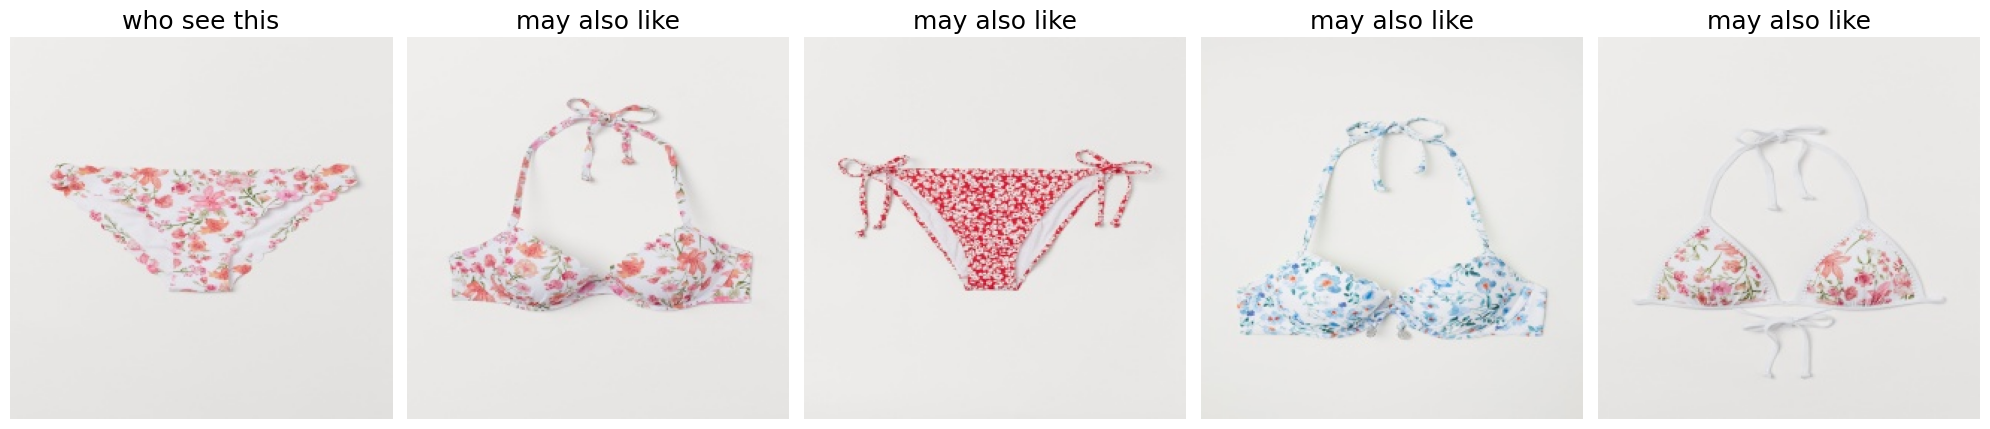

In [14]:
prod2vec_you_may_also_like(1478, model, article_ids)

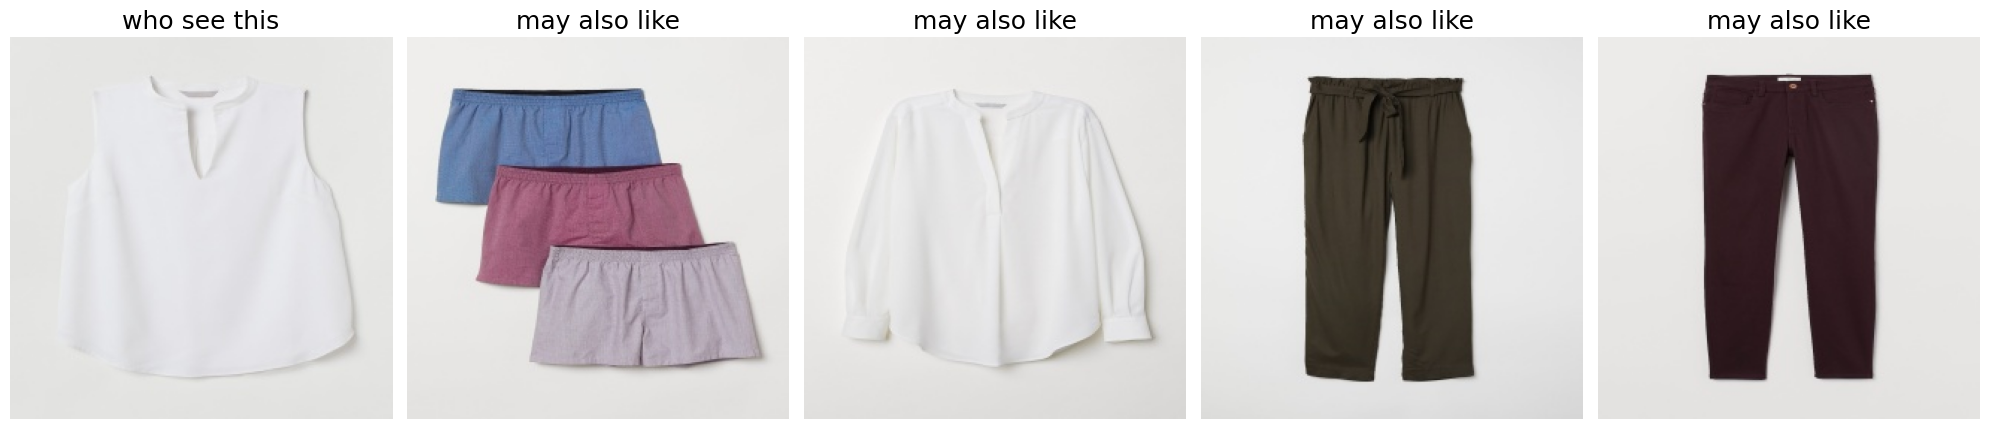

In [15]:
prod2vec_you_may_also_like(23994, model, article_ids)

In [ ]:
## --------------------------------------------------------------------------------------------------------------------- ##

## Other Recommendation Idea

We can pick several last transactions (e.g: 4), take average on these 4 vectors, then use prod2vec to give a recommendation

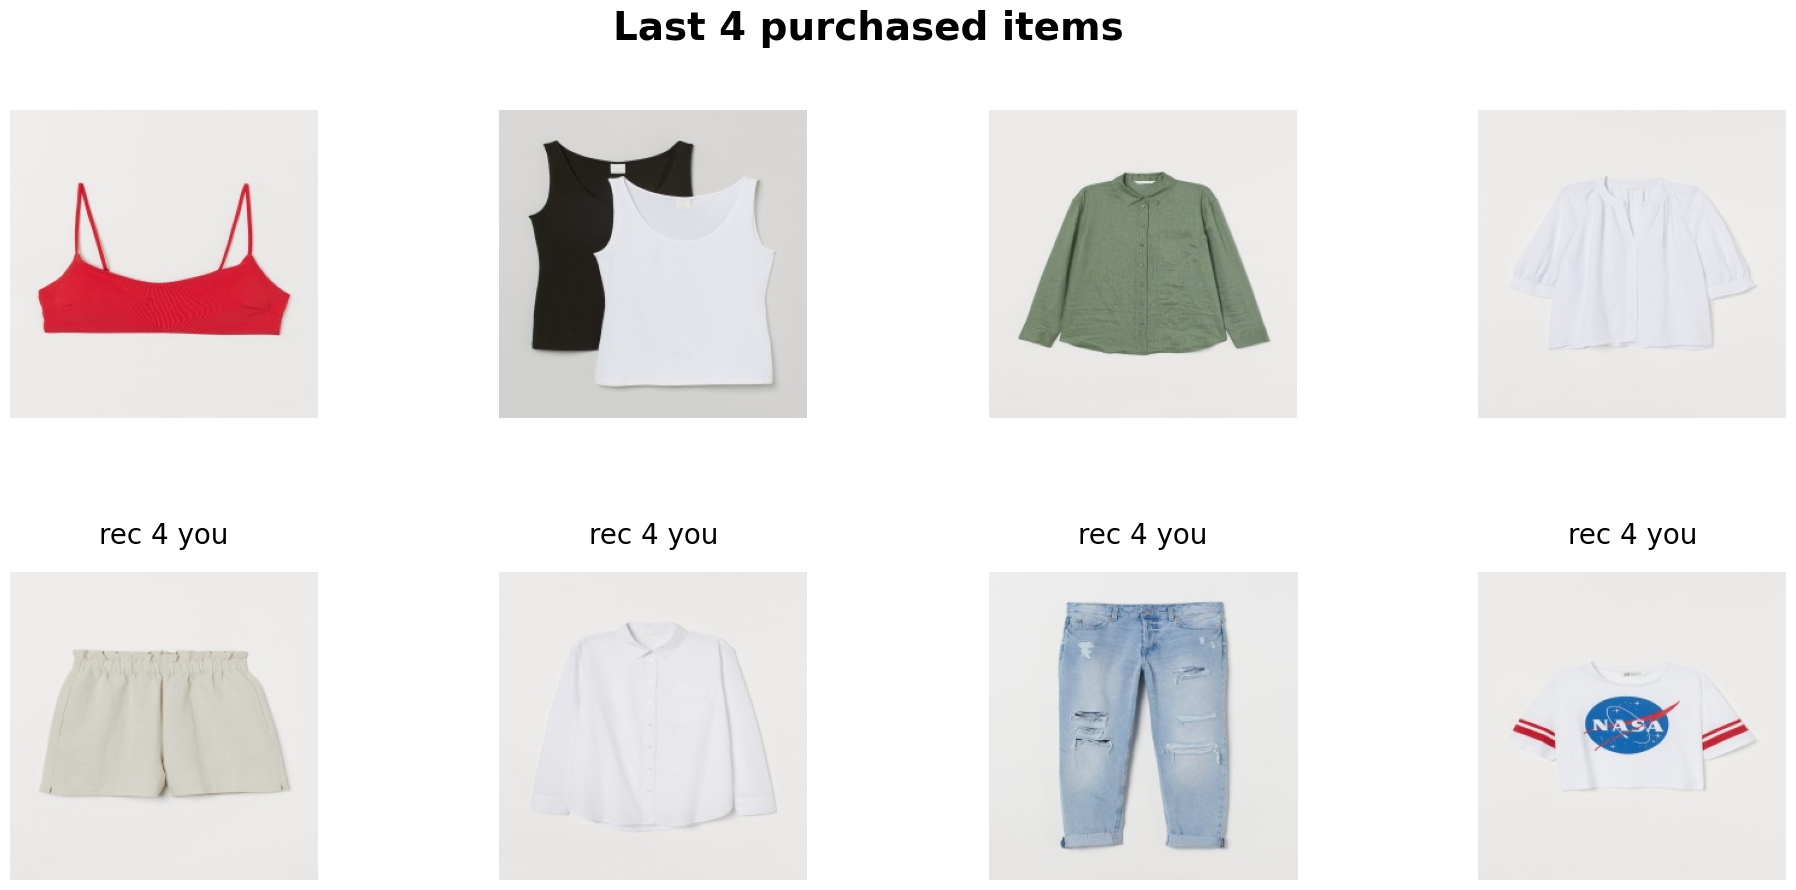

In [19]:
prod2vec_base_on_last_4_purchased(purchases_history[987], model, article_ids)

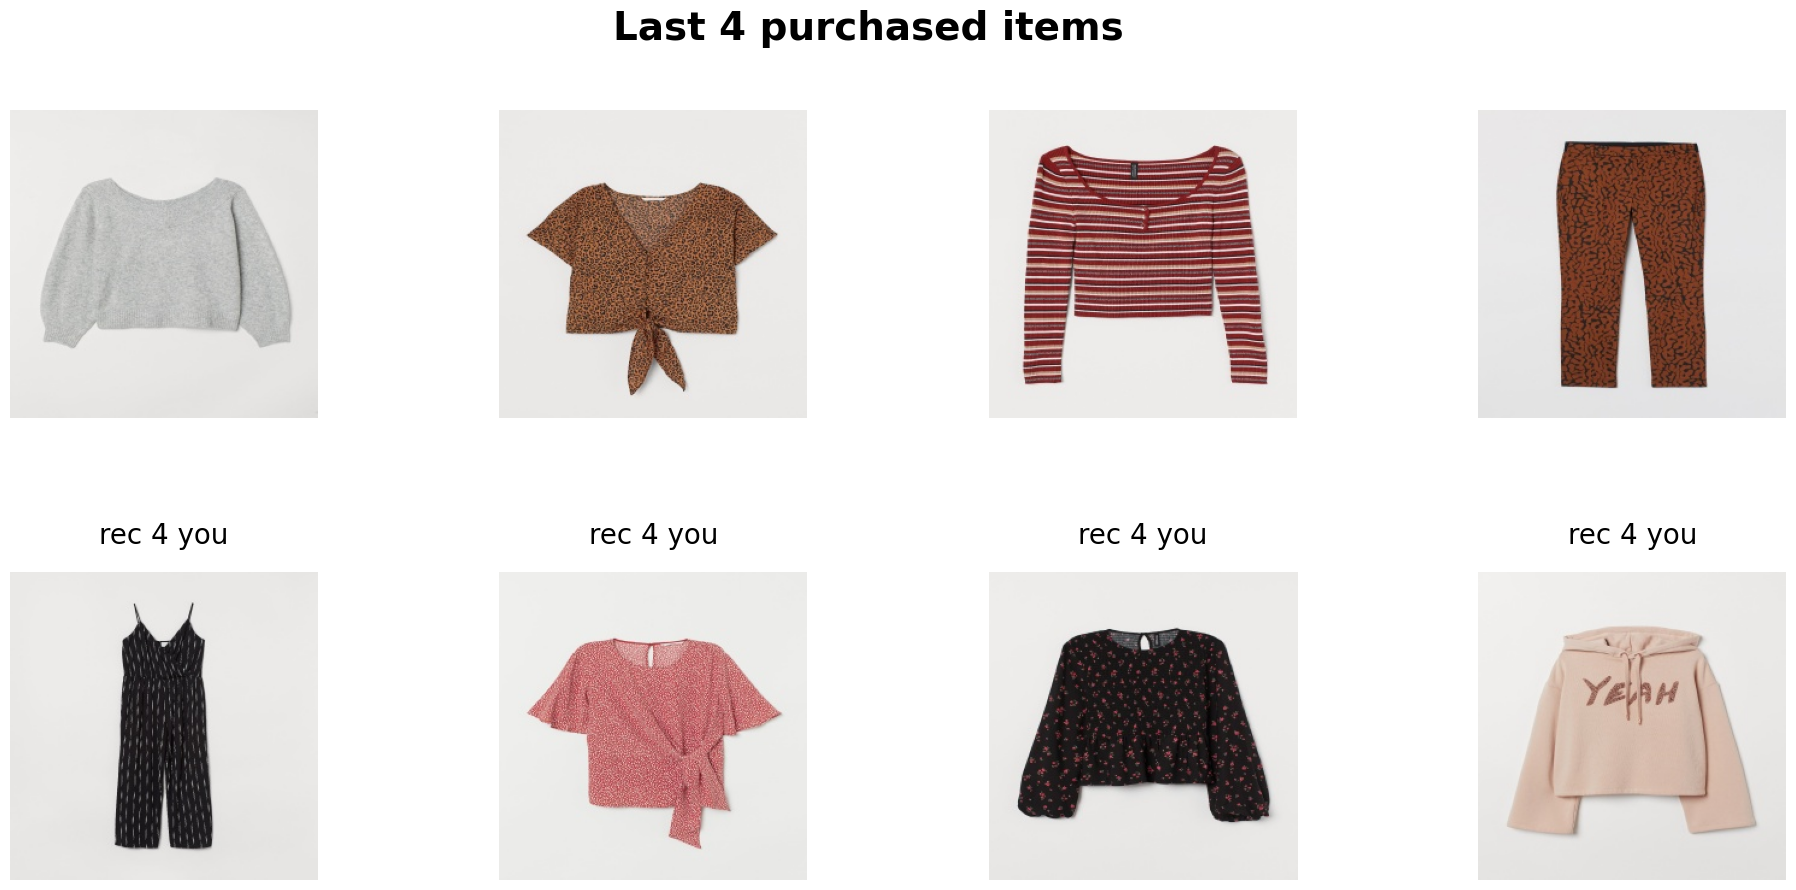

In [20]:
prod2vec_base_on_last_4_purchased(purchases_history[123], model, article_ids)

## Use cases:

- email campaign

- recommendation for you at home-page

In [ ]:
##################################################################################################################
##########################################  To Be Continued  #####################################################
##################################################################################################################

### The importance of thorough business/product understanding of a data scientist

<hr>

Each data-science projects we developed addresses our business problems from a different aspect. Therefore, matching a specific business problem with a proper data solution must be one of the crucial qualities of a data scientist and it requires a good level of product knowledge.

From a technical perspective, a data scientist must be also capable of converting an existing Machine Learning algorithm to fit into his own business problem

## References:

<hr>

- [Word2Vec Tutorial - The Skip-Gram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)

- [Word2Vec Tutorial Part 2 - Negative Sampling](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/)
